# Conversion Rate Challenge


## <font color=red>Aim

Optimizing conversion rates is one of the most important tasks of a data scientist.

That's why we will build a model that will predict the conversion rate of customers on a website and make recommendations to our marketing team to increase our revenue.


## <font color=red>Challenge description

We have collected data about users of a _anonymous_ company's website. Your project is :

1. Create a model to predict the conversion rate (will the user convert or not?).

2. Find recommendations for the Product & Marketing team to make so that they can improve the conversion rate.

## <font color=red>About data
    
CONVERSION RATE of a anonym site found on kggle :-)

In [1]:
!pip install s3fs

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [74]:
dataset = pd.read_csv('s3://full-stack-bigdata-datasets/Machine Learning Supervisé/Projet Conversion Rate/conversion_data.csv')

dataset

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
...,...,...,...,...,...,...
316195,US,26,1,Ads,9,0
316196,US,27,1,Direct,6,0
316197,China,25,0,Ads,4,0
316198,US,22,0,Seo,4,0


# DESCRIPTIVE ANALYSIS 

In [4]:
# Basic stats
print("Number of rows : {} and number of columns is : {}".format(dataset.shape[0],dataset.shape[1]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])



Number of rows : 316200 and number of columns is : 6

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

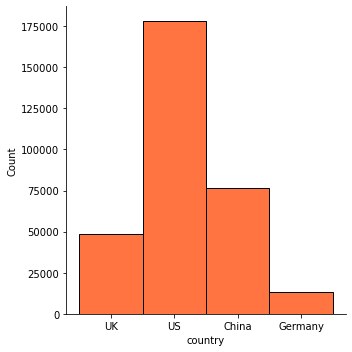

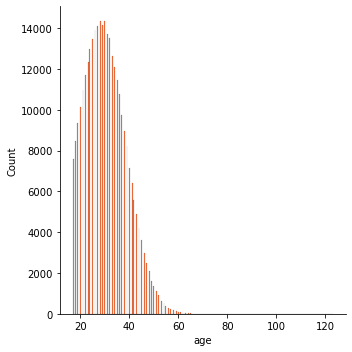

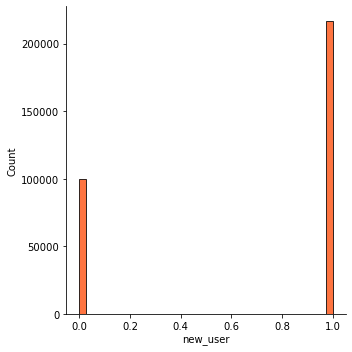

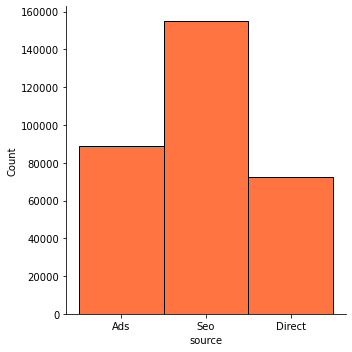

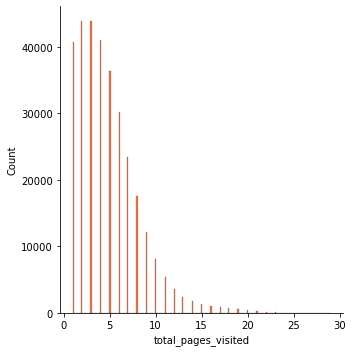

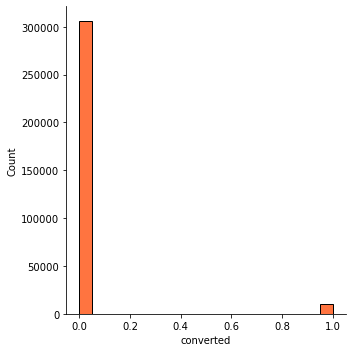

In [5]:
for col in dataset.columns:
    sns.displot(dataset[col],color='orangered')   # thanks emmanuel for this tips

In [6]:
pip install heatmapz

Note: you may need to restart the kernel to use updated packages.


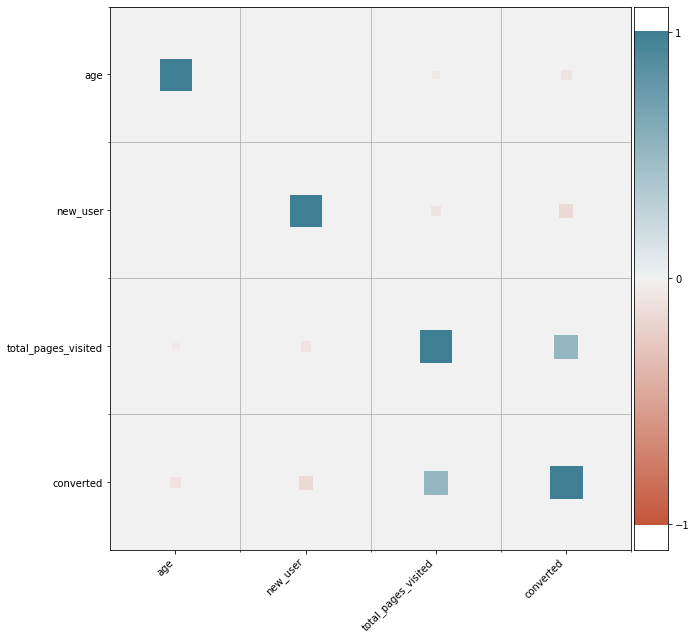

In [7]:
from heatmap import heatmap, corrplot
plt.figure(figsize=(10, 10))
corrplot(dataset.corr(), size_scale=1000);

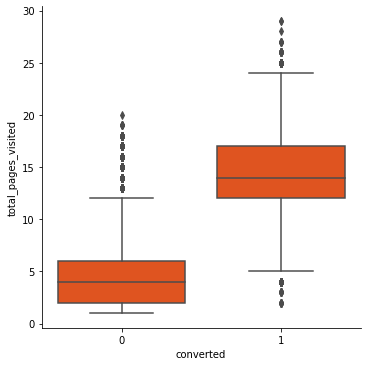

In [8]:
sns.catplot(x='converted',y='total_pages_visited',data=dataset, kind='box', color='orangered')

In [9]:
print(dataset['converted'].value_counts())
print(dataset['converted'].value_counts(normalize = True))

0    306000
1     10200
Name: converted, dtype: int64
0    0.967742
1    0.032258
Name: converted, dtype: float64


#### <font color=green>CONCLUSION
* No missing values
* No uniques values
* Still No important correlation between features
* good positiv correlation between pages numbers and the target (~0.5
* we observe a important imbalance in target (Y=converted) between 0 and  1

# PREPOCESSING

## <font color=blue>1/ Preprocessing  

##### Outliers

In [10]:
dataset.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


### <font color=blue>Age Outlieurs

* we supp Score z + 2 and  Score z -2 for age quantitative values


In [11]:
import scipy

print('.................Age outliers.............')

dataset['score_z_age']=scipy.stats.zscore(dataset['age'])

print(' we got a number of {} age outliers and we have {} left values'
      .format(len(dataset.loc[(dataset['score_z_age'] > 2) 
    | (dataset['score_z_age']< -2),:]), len(dataset)))


dataset = dataset.loc[(dataset['score_z_age'] < 2) & (dataset['score_z_age']> -2),:]


dataset  =dataset.drop('score_z_age',axis=1)

                      
dataset

.................Age outliers.............
 we got a number of 9831 age outliers and we have 316200 left values


,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
...,...,...,...,...,...,...
316195,US,26,1,Ads,9,0
316196,US,27,1,Direct,6,0
316197,China,25,0,Ads,4,0
316198,US,22,0,Seo,4,0


- we just supp outliers from age

- lets see if there are some otehr  outliers too



### <font color=blue>Country variable

In [12]:
dataset['country'].value_counts()

US         172551
China       74133
UK          47016
Germany     12669
Name: country, dtype: int64

- we are choosing to group Germany and Uk to get more homegeneous variables,

In [13]:
dataset['country'] = dataset['country'].apply(lambda x: x.replace('Germany','Europe'))
dataset['country'] = dataset['country'].apply(lambda x: x.replace('UK','Europe'))   


dataset.country.value_counts()

US        172551
China      74133
Europe     59685
Name: country, dtype: int64

### <font color=blue>Balance nex_user variable 

we have actually a high imbalance of one of our indéêndant variable as you can see below

In [14]:

print(dataset['new_user'].value_counts())
print(dataset['new_user'].value_counts(normalize = True))

1    209864
0     96505
Name: new_user, dtype: int64
1    0.685004
0    0.314996
Name: new_user, dtype: float64


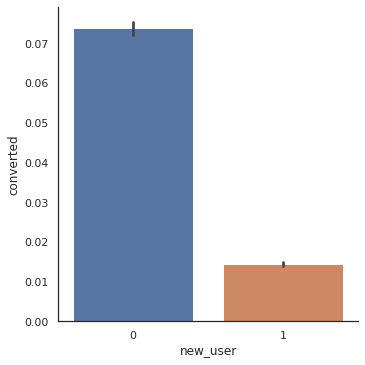

In [15]:
from numpy import mean





from matplotlib.pyplot import show 
import seaborn as sns 
sns.set(style="white") 
total = float(len(dataset)) # one person per row 
#ax = sns.barplot(x="class", hue="who", data=titanic) 
ax = sns.catplot(x = 'new_user' , y = 'converted' , data = dataset,kind='bar') # for Seaborn version 0.7 and more 

show() 

- user_new(0) = he is not  new on site,
- user_new(1) = he is new
----------------------
- converted(0) = they not converted,
- converted(1) = they converted





there, we can easily observe that new ppl (user =1)  still don't convert their money (->0) instead of usual user taht still more convert their money

Thus, to have more homegenous new_user variable, we choosed to divide by 2 the number of new_user in our dataset

In [16]:
dataset[dataset['new_user']==1].value_counts().sum()/2

104932.0

In [17]:

dataset2=dataset

dataset2 =dataset[dataset['new_user'] == 1].sample(n=104932)


indexNames = dataset[dataset['new_user'] == 1 ].index
dataset3=dataset.drop(indexNames , axis=0)


dataset = pd.concat([dataset3,dataset2], ignore_index=True)
display(dataset)

,country,age,new_user,source,total_pages_visited,converted
0,US,31,0,Seo,1,0
1,US,23,0,Ads,4,0
2,Europe,29,0,Direct,4,0
3,US,25,0,Ads,2,0
4,US,38,0,Seo,1,0
...,...,...,...,...,...,...
201432,US,39,1,Direct,3,0
201433,Europe,23,1,Ads,8,0
201434,US,34,1,Seo,2,0
201435,US,43,1,Ads,6,0


# Preprocessing for Machine learning 


#### Séparating dépenndant (Y=converted) variables and indépendant variables (X)

In [18]:
# Separate target variable Y from features X
target_name = 'converted'

print("Separating labels from features...")
Y = dataset.loc[:,target_name]
X = dataset.loc[:,[c for c in dataset.columns if c!=target_name]] # Keeping all columns
print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0    0
1    0
2    0
3    0
4    0
Name: converted, dtype: int64

  country  age  new_user  source  total_pages_visited
0      US   31         0     Seo                    1
1      US   23         0     Ads                    4
2  Europe   29         0  Direct                    4
3      US   25         0     Ads                    2
4      US   38         0     Seo                    1



print("Convert pandas DataFrames to numpy arrays...")
X = X.values
Y = Y.tolist()

In [19]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=Y)

#### <font color=blue>Standardisation of features

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix 
from sklearn import metrics
# import usual lib to normalise and use logistic regression 

In [21]:
X_train

,country,age,new_user,source,total_pages_visited
27078,US,33,0,Ads,1
84580,Europe,27,0,Seo,7
68609,China,33,0,Direct,6
103526,US,21,1,Seo,1
35544,US,34,0,Direct,2
...,...,...,...,...,...
173935,US,44,1,Direct,2
1830,US,34,0,Direct,5
42608,US,26,0,Direct,3
91289,China,33,0,Ads,7


In [22]:
label_features = [2]
numeric_features = [1,4]
numeric_transformer = StandardScaler()

categorical_features = [0, 3]

categorical_transformer = OneHotEncoder()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder ='passthrough')

print('done')

done


In [23]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5])
X_train = preprocessor.fit_transform(X_train)

print('...Done.')
print(X_train[0:5])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5])
X_test = preprocessor.transform(X_test)

print('...Done.')
print(X_test[0:5])
print()

Performing preprocessings on train set...
       country  age  new_user  source  total_pages_visited
27078       US   33         0     Ads                    1
84580   Europe   27         0     Seo                    7
68609    China   33         0  Direct                    6
103526      US   21         1     Seo                    1
35544       US   34         0  Direct                    2
...Done.
[[ 0.41983506 -1.13953094  0.          0.          1.          1.
   0.          0.          0.        ]
 [-0.38290497  0.57731099  0.          1.          0.          0.
   0.          1.          0.        ]
 [ 0.41983506  0.29117067  1.          0.          0.          0.
   1.          0.          0.        ]
 [-1.185645   -1.13953094  0.          0.          1.          0.
   0.          1.          1.        ]
 [ 0.55362506 -0.85339062  0.          0.          1.          0.
   1.          0.          0.        ]]

Performing preprocessings on test set...
       country  age  new_us

In [24]:
labelencoder = LabelEncoder()

print("Encoding labels on train set...")
print(Y_train[0:5])
print()
Y_train = labelencoder.fit_transform(Y_train)
print("...Done.")
print(Y_train[0:5])
print()

print("Encoding labels on test set...")
print(Y_test[0:5])
print()
Y_test = labelencoder.transform(Y_test) # Don't fit again !!
print("...Done.")
print(Y_test[0:5])
print()

Encoding labels on train set...
27078     0
84580     0
68609     0
103526    0
35544     0
Name: converted, dtype: int64

...Done.
[0 0 0 0 0]

Encoding labels on test set...
57992     1
140100    0
193568    0
76240     0
166247    0
Name: converted, dtype: int64

...Done.
[1 0 0 0 0]



# SMOTE METHOD 

we are using one method of pre encoding model called SMOTE, the aim is to help our model to have a better predicion with a really high imbalance  in our dpendent variable Y (0>1), we thus using SMOTE to artificially increase the number of the smallest variable (with the parameter ''sampling_strategy'') and we fit this method on our train set (X_train and Y_train)

In [25]:
!pip install imblearn


In [26]:
from imblearn.over_sampling import SMOTE


print('Before SMOT')
print(dataset['converted'].value_counts())
print("Old train set : Number of 1's : {}, overall number : {}, percentage of 1s : {:.2f}"
      .format(sum(Y_train), len(Y_train), sum(Y_train)/len(Y_train)))


sm = SMOTE(random_state=0,sampling_strategy=0.057,k_neighbors=100)

X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)
print("New train set : Number of 1's : {}, overall number : {}, percentage of 1s : {:.2f}"
      .format(sum(Y_train_res), len(Y_train_res), sum(Y_train_res)/len(Y_train_res)))

Before SMOT
0    192829
1      8608
Name: converted, dtype: int64
Old train set : Number of 1's : 6886, overall number : 161149, percentage of 1s : 0.04
New train set : Number of 1's : 8792, overall number : 163055, percentage of 1s : 0.05


# LOGISTIC REGRESSION

#### - <font color=blue>After using SMOTE method, we are using a simple Logistic regression to predict our Y

In [27]:


# Train model
model = LogisticRegression(solver='liblinear')

print("Training model...")
model.fit(X_train_res, Y_train_res) # Training is always done on train set !!


# Predictions on training set
Y_train_pred_res = model.predict(X_train_res)            


# Predictions on test set
Y_test_pred = model.predict(X_test)


# Using F1_score because there are a high imbalance in our target as we seen previously 
print('\n')
print('............F1 score ...........')
print('"F1 score on training set is :',f1_score(Y_train_res, Y_train_pred_res))
print('"F1 score on test set is :',f1_score(Y_test,Y_test_pred))

Training model...


............F1 score ...........
"F1 score on training set is : 0.8059009997561571
"F1 score on test set is : 0.7843017949498023


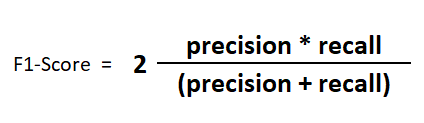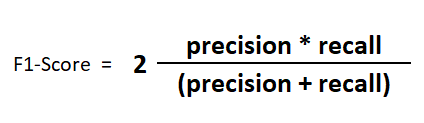

### - <font color=blue>Cross validation 
#####  Let's check if our model is doing overfitting (signitficative difference between f1 score on a multiple samples of train set, then we compare this range of score with the previous result on test set)

In [28]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import f1_score
		


scores = cross_val_score(model, X_train_res, Y_train_res,cv=20,scoring='f1')
print(scores)
print(scores.mean())


[0.8009768  0.78401998 0.79345088 0.8106152  0.8125     0.7873633
 0.80727273 0.79799247 0.80445545 0.79357231 0.79006211 0.81598063
 0.8        0.81851401 0.80481928 0.83511269 0.79330944 0.80820265
 0.80532044 0.84624846]
0.8054894413152065


### - <font color=blue>Learning curve

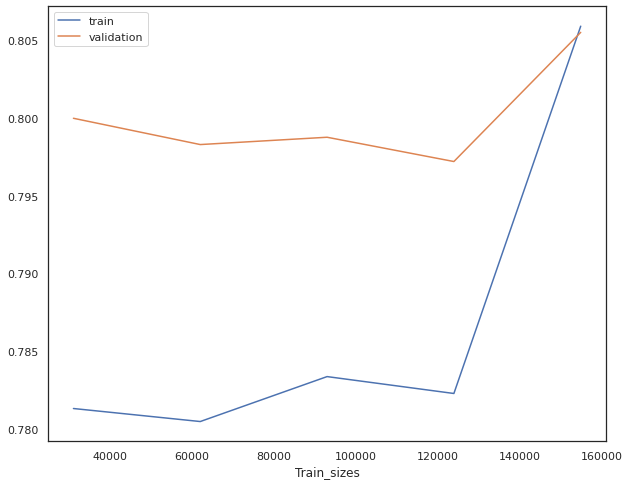

In [29]:
from sklearn.model_selection import learning_curve


N,train_scores, valid_scores = learning_curve(model, X_train_res, Y_train_res, train_sizes = np.linspace(0.2, 1, 5,10),cv=20,n_jobs=-1,scoring='f1')

plt.figure(figsize=(10,8))
plt.plot(N,train_scores.mean(axis = 1),label='train')
plt.plot(N,valid_scores.mean(axis = 1),label='validation')
plt.xlabel('Train_sizes')
plt.legend()
plt.show()

##### * As we can see, Cross validation indicating that our F1_scoe on test set is overfiiting comparatively to the f1score on train set, moreover, the learning curve indicating optional informations about the optimal size of our train set to get the best predicting score  

##### * Let's try a Grisearchcv to know what are the best hyperparameters values to get the best and less overfitting model

### -<font color=blue> Grid Search

In [30]:
from sklearn.model_selection import GridSearchCV

cvs=LogisticRegression()
params =grid_values = {'C':[0.001,0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(cvs, params, cv = 20, verbose=2,n_jobs=-1,scoring='f1')
grid.fit(X_train_res,Y_train_res)  

Fitting 20 folds for each of 6 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   19.8s finished


GridSearchCV(cv=20, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]}, scoring='f1',
             verbose=2)

In [31]:
grid.best_estimator_

LogisticRegression(C=1)

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_true=Y_test, y_pred=grid.best_estimator_.predict(X_test),digits=5,target_names = ['Not converted', 'Converted']))



               precision    recall  f1-score   support

Not converted    0.98882   0.99284   0.99083     38566
    Converted    0.82364   0.74855   0.78430      1722

     accuracy                        0.98240     40288
    macro avg    0.90623   0.87070   0.88756     40288
 weighted avg    0.98176   0.98240   0.98200     40288



##### We got the best estimator used by our logistic model with hyperparaeter C = 1 as the best paramater estimator, as wwe can see, C=1 was a default parameter of our previous logistic regression, thus, we don't need to change hyperparameter value of our modelto get a better prediction F1_score

### -<font color=blue>Confusion Matrix

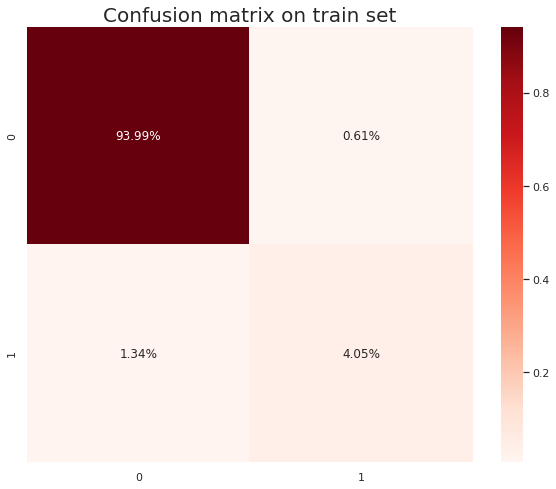

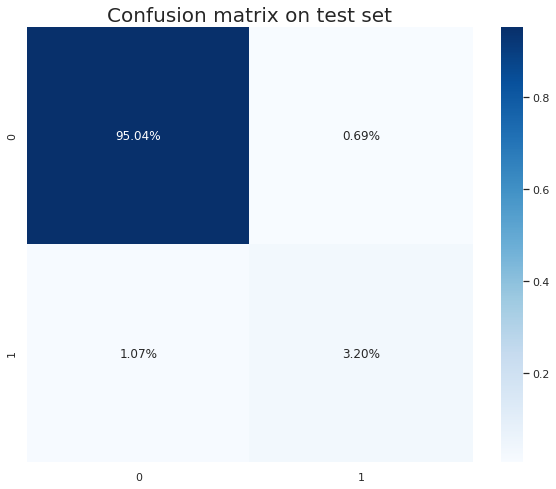

In [33]:
import numpy as np
from sklearn import metrics

cm = metrics.confusion_matrix(Y_train_res, Y_train_pred_res) 

# Visualize confusion matrix 
import seaborn as sns 
plt.figure(figsize=(10,8))
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Reds')
plt.title('Confusion matrix on train set', fontsize = 20)
plt.show()
cm = metrics.confusion_matrix(Y_test, Y_test_pred) 

# Visualize confusion matrix 
import seaborn as sns 
plt.figure(figsize=(10,8))
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')
plt.title('Confusion matrix on test set', fontsize = 20)
plt.show()

### - <font color=blue>Roc curve

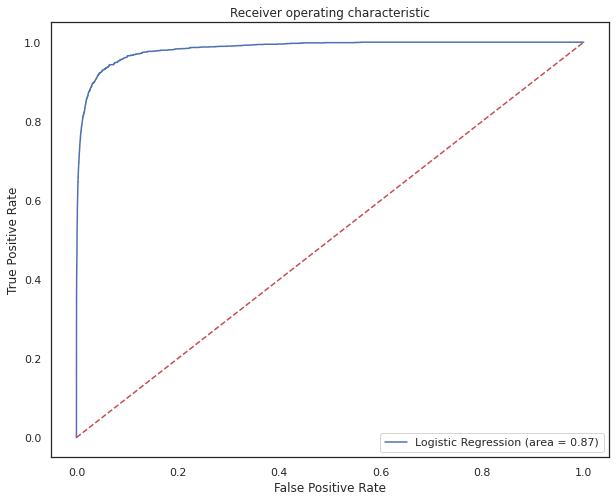

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, model.predict_proba(X_test)[:,1]) 
"""on séléctionne la colonne 1 de predict proba car on a une colonne par classe de y
et qu'on a besoin e P(y=1)"""


plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). our Logisti regression model show that the curves is closer to the top-left corner taht indicating a better performance. ... The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

## <font color=blue>Feature's importance

In [75]:
dataset.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [76]:

#importing necessary lib to get a table of F and p_value (like in R) :
import statsmodels.api as sm
from statsmodels.formula.api import ols


#creating models of Anova on each score variables : 
model_total1 = ols('converted ~  country + age +new_user+source	+ total_pages_visited', data=dataset).fit()


anova_table1 = sm.stats.anova_lm(model_total1,  typ=2).sort_values(by = 'F',ascending=False)


print('----------------------------------------------------------------------')
print('Variables effect on writing score : ')
display(anova_table1)
print('\n')
print('----------------------------------------------------------------------')


----------------------------------------------------------------------
Variables effect on writing score : 


,sum_sq,df,F,PR(>F)
total_pages_visited,2564.381076,1.0,117567.555806,0.000000e+00
new_user,114.523893,1.0,5250.504418,0.000000e+00
age,39.444072,1.0,1808.367383,0.000000e+00
country,53.889069,3.0,823.539343,0.000000e+00
source,0.669063,2.0,15.337049,2.185381e-07
Residual,6896.751500,316191.0,NaN,NaN




----------------------------------------------------------------------


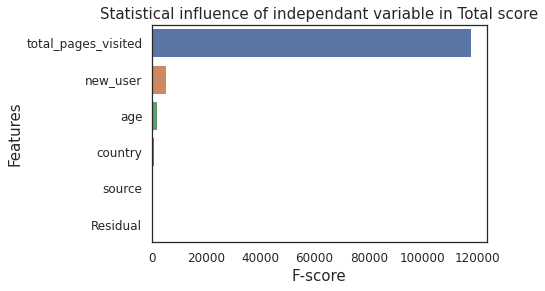

In [77]:

sns.barplot(x=anova_table1['F'], y=anova_table1.index, data=anova_table1)
plt.xlabel('F-score', fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel('Features', fontsize = 15)
plt.yticks(fontsize = 12)
plt.title("Statistical influence of independant variable in Total score", fontsize = 15)
plt.show()

In [80]:
dataset.new_user = dataset.new_user.apply(lambda x: 'new_user' if x == 1 else 'subscriber_user')

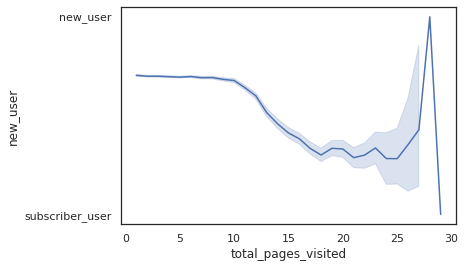

In [84]:
sns.lineplot(dataset.total_pages_visited, dataset.new_user)
plt.show()

#### <font color=green>CONCLUSION
* Significance of features on the variation of Y ( p<0.05 )
* The number of visited pages is the most significative feature (see table f_score)


# <font color=red>CONCLUSION


   With a good preprocessing additionaly to a SMOTE method, Our model have a good prediction score on X_test, however, we would need other test set to improve our model and compare the theory with reality, moreover, we would need to use other model to compare with the logistic regression score, finnally,to understand better the underlying process that lead customers to convert or to not convert, we used a anova test that show a significance of every feature with a most significative influence of the total visiting pages and being a new user or not.
    
    
Nb : if you this notebook has been done during the training course at jedha bootcamp in Novembre 2020 and need to be reviewed later when i'll be a data-scientist :-)